# Ammonia Dispersion Prediction using Deep Learning

This notebook implements a deep learning model to predict ammonia concentration and threat zones based on environmental conditions.

## Features:
- Predicts indoor and outdoor ammonia concentrations (ppm)
- Predicts threat zone distances (Red, Orange, Yellow zones in miles)
- Uses neural networks with hyperparameter optimization
- Comprehensive visualization and performance metrics

## Authors:
Research conducted at University of Engineering and Technology (UET)

## License:
MIT License - See LICENSE file for details

## 1. Import Required Libraries

Install required packages if needed:
```bash
pip install numpy pandas matplotlib scikit-learn tensorflow keras-tuner tabulate openpyxl
```

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

import tensorflow as tf
from tensorflow import keras
import tabulate
from tensorflow.keras import layers
import keras_tuner as kt

print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")

TensorFlow Version: 2.15.0
NumPy Version: 1.26.4
Pandas Version: 2.2.3


## 2. Load Dataset

**Note:** Make sure `unique_points.xlsx` is in the same directory as this notebook.

### Input Features:
- Air Temperature (°C)
- Wind Speed (m/s)
- Hole Diameter (mm)

### Target Variables:
- Indoor Concentration (ppm)
- Outdoor Concentration (ppm)
- Red Zone (miles)
- Orange Zone (miles)
- Yellow Zone (miles)

In [23]:
# Load Dataset
data = pd.read_excel("unique_points.xlsx", sheet_name="Sheet1")

# Display basic information
print(f"Dataset Shape: {data.shape}")
print("\nFirst few rows:")
display(data.head())

print("\nDataset Statistics:")
display(data.describe())

Dataset Shape: (4000, 10)

First few rows:


,Pressure (atm),Air Temperature (°C),Wind Speed (m/s),Hole Diameter (mm),Indoor Concentration (ppm),Outdoor Concentraton (ppm),Red Zone (Yards),Orange Zone (miles),Yellow Zone (miles),Red Zone (miles)
0,3.1,10.0,6.1,334,3460,172000,1440,1.8,3.5,0.818182
1,1.8,10.0,5.7,256,3690,197300,1482,1.8,3.6,0.842046
2,4.1,10.0,8.7,498,3550,125700,1333,1.8,3.6,0.757387
3,1.3,10.1,4.8,984,4030,264000,1526,1.9,3.6,0.867046
4,1.3,10.1,9.2,979,3500,120400,1308,1.8,3.6,0.743182



Dataset Statistics:


,Pressure (atm),Air Temperature (°C),Wind Speed (m/s),Hole Diameter (mm),Indoor Concentration (ppm),Outdoor Concentraton (ppm),Red Zone (Yards),Orange Zone (miles),Yellow Zone (miles),Red Zone (miles)
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000
mean,2.982600,29.890450,4.990200,499.580750,4538.830000,3.866822e+05,1464.894750,1.828192,3.557150,0.832327
std,1.151627,11.444262,2.864904,284.150615,1957.116925,3.824110e+05,173.109962,0.157463,0.267192,0.098358
min,1.000000,10.000000,0.100000,10.000000,670.000000,4.800000e+03,217.000000,0.400000,1.000000,0.123295
25%,2.000000,19.800000,2.500000,252.000000,3680.000000,1.443000e+05,1386.000000,1.800000,3.600000,0.787500
50%,3.000000,29.900000,4.900000,500.000000,3860.000000,2.263500e+05,1502.000000,1.900000,3.600000,0.853409
75%,4.000000,39.700000,7.400000,745.000000,4340.000000,3.927250e+05,1584.000000,1.900000,3.700000,0.900000
max,5.000000,50.000000,10.000000,1000.000000,14500.000000,1.520000e+06,1673.000000,2.000000,3.800000,0.950568


In [24]:
# Features
X = data[["Air Temperature (°C)", "Wind Speed (m/s)", "Hole Diameter (mm)"]]

# Targets (includes threat zones)
y = data[['Indoor Concentration (ppm)', 'Outdoor Concentraton (ppm)',
          'Red Zone (miles) ', 'Orange Zone (miles) ', 'Yellow Zone (miles)']]

print(f"Features Shape: {X.shape}")
print(f"Targets Shape: {y.shape}")

Features Shape: (4000, 3)
Targets Shape: (4000, 5)


## 3. Data Preprocessing

Scale features and targets using MinMaxScaler to normalize values between 0 and 1.

In [25]:
# Scale Features and Targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("Scaling completed!")
print(f"Scaled Features range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")
print(f"Scaled Targets range: [{y_scaled.min():.3f}, {y_scaled.max():.3f}]")

Scaling completed!
Scaled Features range: [0.000, 1.000]
Scaled Targets range: [0.000, 1.000]


## 4. Train-Test Split

Split data into training (80%) and testing (20%) sets.

In [26]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 3200
Testing samples: 800


## 5. Hyperparameter Tuning (Optional)

This section uses Keras Tuner to find the best hyperparameters. 

**Note:** Set `run_hyperparameter_tuning = True` to run tuning (may take considerable time).

In [27]:
# Hyperparameter Tuning using Keras Tuner
run_hyperparameter_tuning = False  # Set to True to run tuning

if run_hyperparameter_tuning:
    def build_model(hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))

        for i in range(hp.Int("num_layers", 2, 3)):
            model.add(layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                activation='relu'
            ))
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', 0.0, 0.4, step=0.1)))

        model.add(layers.Dense(5))  # Output: 5 targets

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
            ),
            loss="mse",
            metrics=["mae", "mse", keras.metrics.RootMeanSquaredError()]
        )

        return model

    # Initialize the tuner
    tuner = kt.RandomSearch(
        build_model,
        objective="val_loss",
        max_trials=10,
        executions_per_trial=2,
        overwrite=True,
        directory="tuner_dir",
        project_name="indoor_outdoor_conc"
    )

    # Run the tuner
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    
    print("Starting hyperparameter search...")
    tuner.search(X_train, y_train, epochs=100, validation_split=0.2, 
                 callbacks=[early_stop], verbose=1)

    # Retrieve best model and hyperparameters
    best_hp = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters Found:")
    print(best_hp.values)
else:
    print("Hyperparameter tuning skipped. Using pre-optimized parameters.")

Hyperparameter tuning skipped. Using pre-optimized parameters.


## 6. Build and Train the Model

Using the best hyperparameters found during tuning (or pre-optimized values).

In [28]:
# Best Hyperparameters (pre-optimized)
best_hp_values = {
    'num_layers': 3,
    'units_0': 256,
    'dropout_0': 0.3,
    'units_1': 160,
    'dropout_1': 0.1,
    'learning_rate': 0.00047590319258532097,
    'units_2': 160,
    'dropout_2': 0.0
}

print("Best Hyperparameters:")
print(best_hp_values)

Best Hyperparameters:
{'num_layers': 3, 'units_0': 256, 'dropout_0': 0.3, 'units_1': 160, 'dropout_1': 0.1, 'learning_rate': 0.00047590319258532097, 'units_2': 160, 'dropout_2': 0.0}


In [29]:
# Build Keras Model Based on Best Hyperparameters
model = keras.Sequential()

for i in range(best_hp_values['num_layers']):
    model.add(layers.Dense(
        units=best_hp_values[f'units_{i}'],
        activation='relu'
    ))
    model.add(layers.Dropout(rate=best_hp_values[f'dropout_{i}']))

model.add(layers.Dense(5))  # Output: 5 targets

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hp_values['learning_rate']),
    loss="mse",
    metrics=["mae", "mse", keras.metrics.RootMeanSquaredError()]
)

print("\nModel Architecture:")
model.build(input_shape=(None, X_train.shape[1]))
model.summary()


Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 160)            │        41,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 160)            │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,709 (268.39 KB)

 Trainable params: 68,709 (268.39 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

print("Training the model...\n")
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining completed!")

Training the model...

Epoch 1/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2270 - mae: 0.3711 - mse: 0.2270 - root_mean_squared_error: 0.4615 - val_loss: 0.0283 - val_mae: 0.1249 - val_mse: 0.0283 - val_root_mean_squared_error: 0.1683
Epoch 2/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - mae: 0.1206 - mse: 0.0255 - root_mean_squared_error: 0.1595 - val_loss: 0.0124 - val_mae: 0.0851 - val_mse: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 3/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - mae: 0.0843 - mse: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0073 - val_mae: 0.0641 - val_mse: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 4/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mae: 0.0747 - mse: 0.0113 - root_mean_squared_error: 0.1060 - val_loss: 0.0051 - val_mae: 0.0481 - val_mse: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 5/200
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - mae: 0.0638 - mse: 0.0081

## 7. Model Evaluation

Evaluate the model on the test set.

In [31]:
# Evaluate the Model
test_loss, test_mae, test_mse, test_rmse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test Loss: 0.0004
Test MAE: 0.0132
Test MSE: 0.0004
Test RMSE: 0.0207


## 8. Make Predictions

Generate predictions and inverse transform to original scale.

In [32]:
# Predict and Inverse Scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

print(f"Predictions generated for {len(y_pred)} test samples.")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predictions generated for 800 test samples.


## 9. Performance Metrics for All Outputs

Calculate detailed metrics for each output variable.

In [33]:
# Performance Metrics for All Outputs
output_names = ['Indoor (ppm)', 'Outdoor (ppm)', 'Red Zone (miles)', 
                'Orange Zone (miles)', 'Yellow Zone (miles)']

metrics_table = []
for i, name in enumerate(output_names):
    rmse = root_mean_squared_error(y_actual[:, i], y_pred[:, i])
    r2 = r2_score(y_actual[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_actual[:, i], y_pred[:, i])
    mape = (mae / np.mean(y_actual[:, i])) * 100

    metrics_table.append([name, f"{rmse:.4f}", f"{r2:.4f}", f"{mae:.4f}", f"{mape:.2f}%"])

table = pd.DataFrame(metrics_table, columns=["Output", "RMSE", "R²", "MAE", "MAPE"])
print("\nPerformance Metrics:")
print(tabulate.tabulate(metrics_table, headers=["Output", "RMSE", "R²", "MAE", "MAPE"], 
                        tablefmt="github"))
display(table)


Performance Metrics:
| Output              |       RMSE |     R² |        MAE | MAPE   |
|---------------------|------------|--------|------------|--------|
| Indoor (ppm)        |   291.448  | 0.9715 |   154.19   | 3.47%  |
| Outdoor (ppm)       | 26392.6    | 0.9947 | 16272.5    | 4.36%  |
| Red Zone (miles)    |     0.0161 | 0.9658 |     0.0106 | 1.27%  |
| Orange Zone (miles) |     0.0385 | 0.9187 |     0.0271 | 1.47%  |
| Yellow Zone (miles) |     0.0589 | 0.9349 |     0.0406 | 1.14%  |


,Output,RMSE,R²,MAE,MAPE
0,Indoor (ppm),291.4479,0.9715,154.1900,3.47%
1,Outdoor (ppm),26392.5828,0.9947,16272.5153,4.36%
2,Red Zone (miles),0.0161,0.9658,0.0106,1.27%
3,Orange Zone (miles),0.0385,0.9187,0.0271,1.47%
4,Yellow Zone (miles),0.0589,0.9349,0.0406,1.14%


## 10. Visualizations

### 10.1 Training Loss Curve

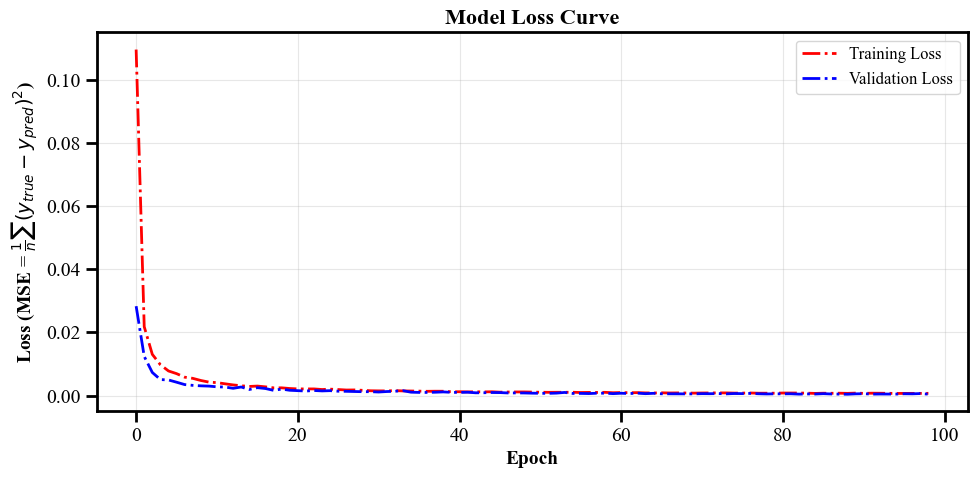

In [34]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))

fontfamily = {'family': 'Times New Roman', 'weight': 'regular', 'size': 14}
plt.rc('font', **fontfamily)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

plt.plot(history.history['loss'], label='Training Loss', color='red', linewidth=2, linestyle='-.')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linewidth=2, linestyle='-.')

plt.title('Model Loss Curve', weight='bold')
plt.xlabel('Epoch', weight='bold')
plt.ylabel(r'Loss (MSE = $\frac{1}{n} \sum (y_{true} - y_{pred})^2$)', weight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 10.2 Predicted vs Actual Values

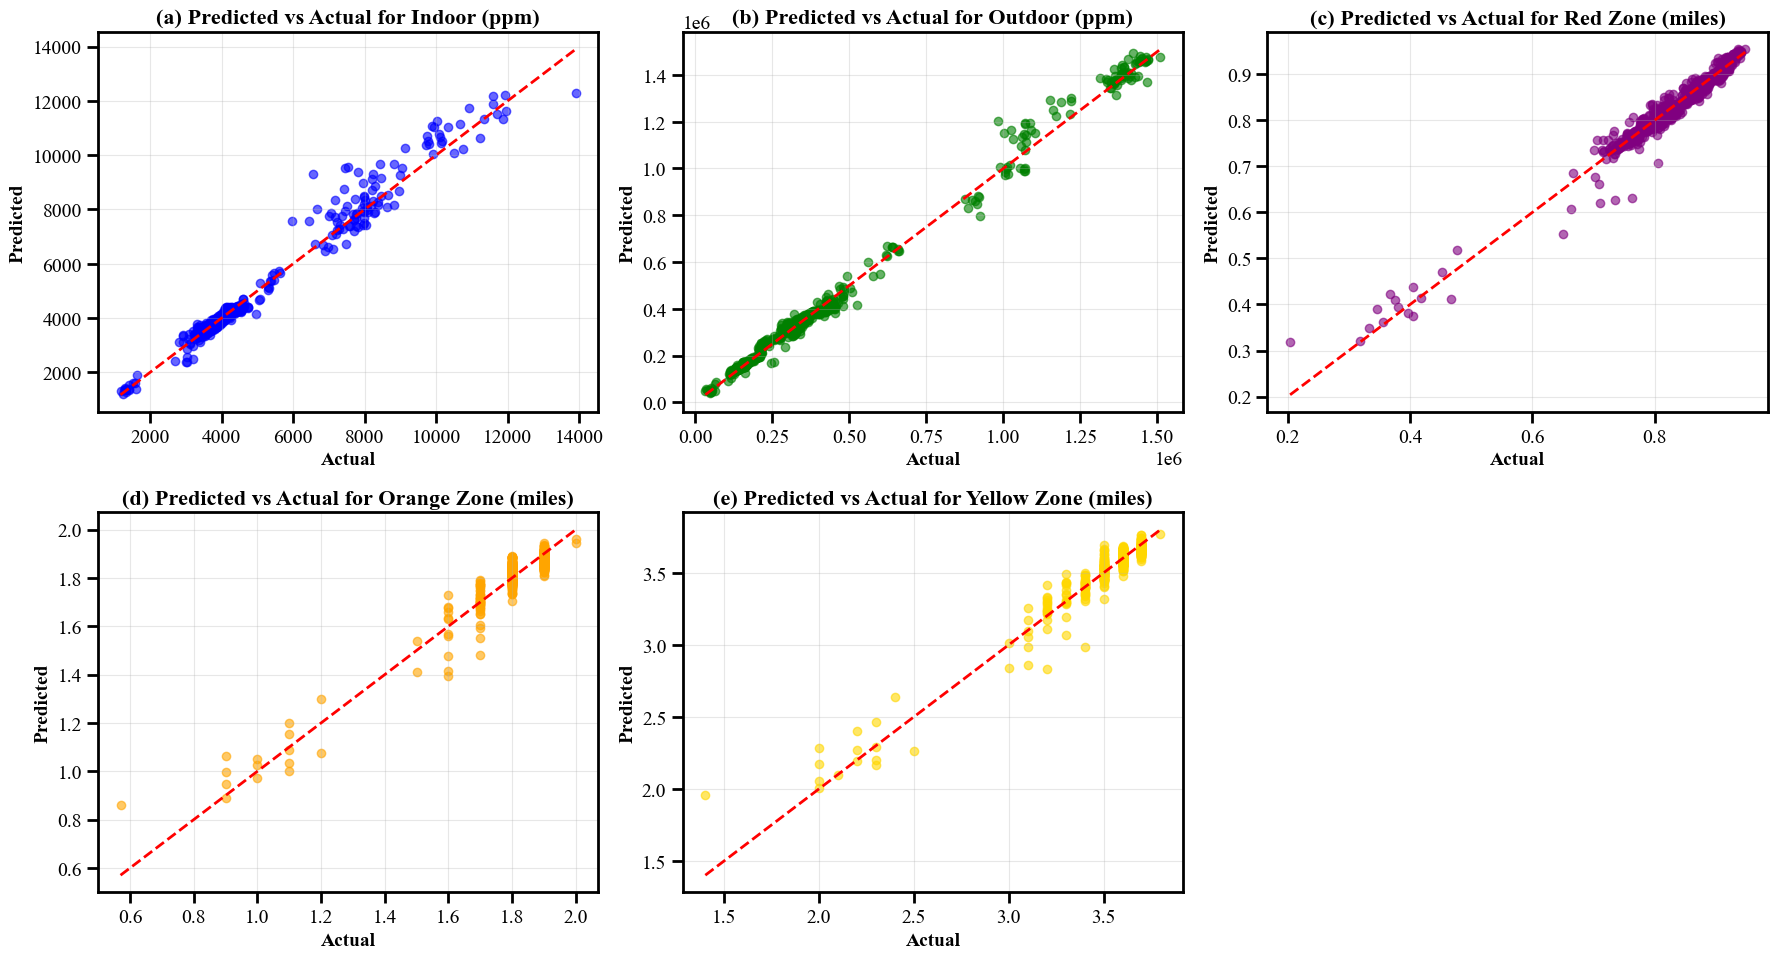

In [35]:
# Predicted vs Actual
plt.figure(figsize=(18, 10))
colors = ['blue', 'green', 'purple', 'orange', 'gold']

for i, name in enumerate(output_names):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_actual[:, i], y_pred[:, i], color=colors[i], alpha=0.6)
    plt.plot([min(y_actual[:, i]), max(y_actual[:, i])], 
             [min(y_actual[:, i]), max(y_actual[:, i])], 'r--', linewidth=2)
    plt.title(f'({chr(97+i)}) Predicted vs Actual for {name}', weight='bold')
    plt.xlabel('Actual', weight='bold')
    plt.ylabel('Predicted', weight='bold')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 10.3 Threat Zones Comparison Bar Chart

In [36]:
# Output Names and Labels
zone_labels = output_names[2:5]  # Red, Orange, Yellow
stats_labels = ['Min', 'Mean', 'Max']
hatch_patterns = ['///', '...', 'xxx']

# Calculate Summary Stats
summary_actual = []
summary_pred = []
input_points = []

X_test_Inv = scaler_X.inverse_transform(X_test)  # Inverse transform for input points

for i in range(2, 5):  # Red, Orange, Yellow
    actual = y_actual[:, i]
    pred = y_pred[:, i]
    summary_actual.append([np.min(actual), np.mean(actual), np.max(actual)])
    summary_pred.append([np.min(pred), np.mean(pred), np.max(pred)])
    
    # Indices for min, mean (closest), and max
    min_idx = np.argmin(actual)
    max_idx = np.argmax(actual)
    mean_val = np.mean(actual)
    mean_idx = np.argmin(np.abs(actual - mean_val))

    input_points.append([
        X_test_Inv[min_idx],   # Input for min actual
        X_test_Inv[mean_idx],  # Input for mean actual
        X_test_Inv[max_idx]    # Input for max actual
    ])

summary_actual = np.array(summary_actual)
summary_pred = np.array(summary_pred)

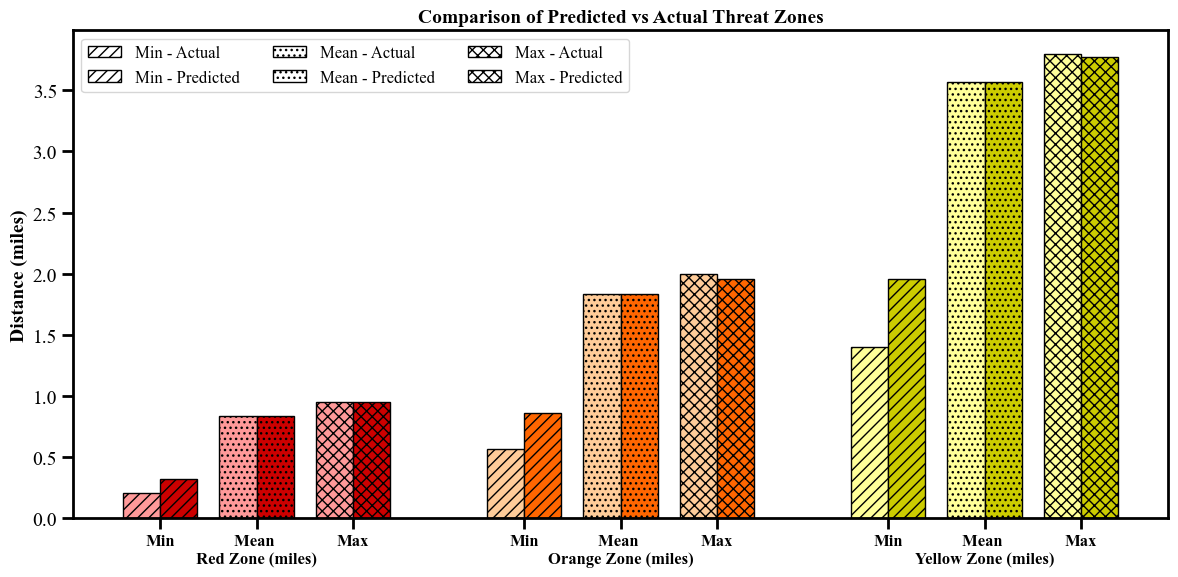

In [37]:
# Bar Plot Setup
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.5
group_spacing = 1.3
zone_spacing = 1
tick_positions = []
tick_labels = []

zone_colors = [
    ('#ff9999', '#cc0000'),  # Red Zone
    ('#ffcc99', '#ff6600'),  # Orange Zone
    ('#ffff99', '#cccc00'),  # Yellow Zone
]

current_pos = 0

# Draw Bars
for zone_idx, (zone, (actual_color, pred_color)) in enumerate(zip(zone_labels, zone_colors)):
    for stat_idx, stat in enumerate(stats_labels):
        actual_val = summary_actual[zone_idx][stat_idx]
        pred_val = summary_pred[zone_idx][stat_idx]

        actual_pos = current_pos
        pred_pos = current_pos + bar_width

        # Bar with hatch patterns
        ax.bar(actual_pos, actual_val, width=bar_width, color=actual_color, edgecolor='black',
               hatch=hatch_patterns[stat_idx], label=f'{stat} - Actual' if zone_idx == 0 else "")
        ax.bar(pred_pos, pred_val, width=bar_width, color=pred_color, edgecolor='black',
               hatch=hatch_patterns[stat_idx], label=f'{stat} - Predicted' if zone_idx == 0 else "")

        # Add tick labels
        tick_positions.append((actual_pos + pred_pos)/2)
        if stat == 'Mean':
            tick_labels.append(f'{stat} \n{zone}')
        else:
            tick_labels.append(f'{stat}')

        current_pos += group_spacing

    current_pos += zone_spacing

# Axis and Legend
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=12, weight='bold')
ax.set_ylabel('Distance (miles)', weight='bold')
ax.set_title('Comparison of Predicted vs Actual Threat Zones', fontsize=14, weight='bold')

# Custom legend
import matplotlib.patches as mpatches
legend_labels = ['Min - Actual', 'Min - Predicted', 'Mean - Actual', 
                 'Mean - Predicted', 'Max - Actual', 'Max - Predicted']
hatches = ['///', '///', '...', '...', 'xxx', 'xxx']
handles = [
    mpatches.Patch(facecolor='white', edgecolor='black', hatch=h, label=l)
    for h, l in zip(hatches, legend_labels)
]
ax.legend(handles=handles, ncol=3, loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

### 10.4 Combined Input-Output Summary Table

In [38]:
# Combined Table of Input Points, Actual, Predicted Summary
combined_table = []
for zone_idx, zone in enumerate(zone_labels):
    for stat_idx, stat in enumerate(stats_labels):
        inputs = input_points[zone_idx][stat_idx]
        row = {
            'Zone': zone,
            'Stat': stat,
            'Air Temperature (°C)': f"{inputs[0]:.2f}",
            'Wind Speed (m/s)': f"{inputs[1]:.2f}",
            'Hole Diameter (mm)': f"{inputs[2]:.2f}",
            'Actual': f"{summary_actual[zone_idx][stat_idx]:.4f}",
            'Predicted': f"{summary_pred[zone_idx][stat_idx]:.4f}"
        }
        combined_table.append(row)

combined_df = pd.DataFrame(combined_table)
print("\nCombined Input & Output Summary Table:")
display(combined_df)

# Save to Excel
combined_df.to_excel("combined_input_output_summary.xlsx", index=False)
print("\nTable saved to 'combined_input_output_summary.xlsx'")


Combined Input & Output Summary Table:


,Zone,Stat,Air Temperature (°C),Wind Speed (m/s),Hole Diameter (mm),Actual,Predicted
0,Red Zone (miles),Min,27.20,9.00,16.00,0.2040,0.3191
1,Red Zone (miles),Mean,42.40,6.10,220.00,0.8362,0.8352
2,Red Zone (miles),Max,47.30,0.80,970.00,0.9477,0.9539
3,Orange Zone (miles),Min,27.20,9.00,16.00,0.5700,0.8602
4,Orange Zone (miles),Mean,15.30,5.20,605.00,1.8372,1.8326
5,Orange Zone (miles),Max,43.20,0.50,928.00,2.0000,1.9595
6,Yellow Zone (miles),Min,27.20,9.00,16.00,1.4000,1.9544
7,Yellow Zone (miles),Mean,15.60,0.50,164.00,3.5676,3.5677
8,Yellow Zone (miles),Max,47.30,0.80,970.00,3.8000,3.7697



Table saved to 'combined_input_output_summary.xlsx'


### 10.5 Residual Plots (Normalized)

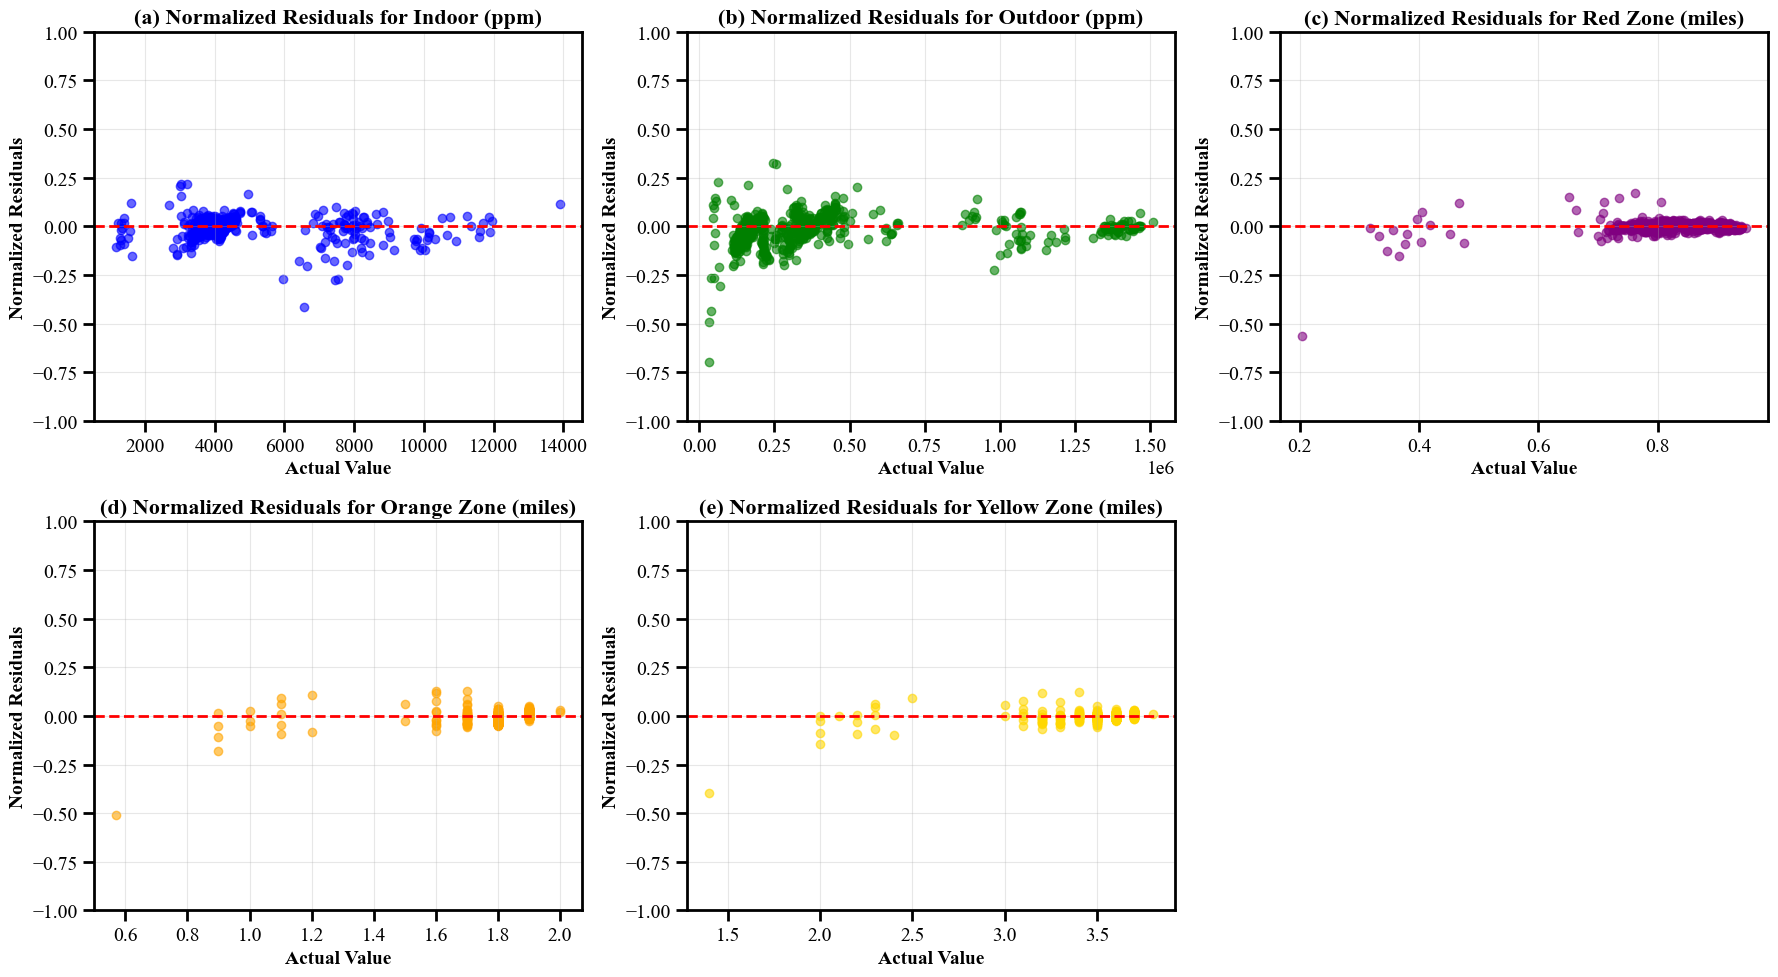

In [39]:
# Residual Plots (Normalized)
plt.figure(figsize=(18, 10))

for i, name in enumerate(output_names):
    residuals = y_actual[:, i] - y_pred[:, i]
    norm_residuals = residuals / (y_actual[:, i] + 1e-8)

    plt.subplot(2, 3, i+1)
    plt.scatter(y_actual[:, i], norm_residuals, color=colors[i], alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.title(f'({chr(97+i)}) Normalized Residuals for {name}', weight='bold')
    plt.xlabel('Actual Value', weight='bold')
    plt.ylabel('Normalized Residuals', weight='bold')
    plt.ylim(-1, 1)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Save the Model (Optional)

Save the trained model for future use.

In [40]:
# Save the model
model.save('ammonia_dispersion_model.keras')
print("Model saved as 'ammonia_dispersion_model.keras'")

# Save scalers
import pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print("Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'")

Model saved as 'ammonia_dispersion_model.keras'
Scalers saved as 'scaler_X.pkl' and 'scaler_y.pkl'


## 12. Make Predictions on New Data (Optional)

Example of how to use the trained model for predictions.

In [41]:
# Example: Predict for new input
new_data = np.array([
    [25.0, 5.0, 10.0],  # Air Temp (°C), Wind Speed (m/s), Hole Diameter (mm)
    [30.0, 3.0, 15.0],
])

# Scale the input
new_data_scaled = scaler_X.transform(new_data)

# Make predictions
predictions_scaled = model.predict(new_data_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Display predictions
predictions_df = pd.DataFrame(
    predictions,
    columns=['Indoor (ppm)', 'Outdoor (ppm)', 'Red Zone (miles)', 
             'Orange Zone (miles)', 'Yellow Zone (miles)']
)
print("\nPredictions for new data:")
display(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Predictions for new data:


c:\anaconda3\envs\ANN\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Indoor (ppm),Outdoor (ppm),Red Zone (miles),Orange Zone (miles),Yellow Zone (miles)
0,1866.653809,84738.867188,0.500874,1.196768,2.510215
1,3650.000488,344605.281250,0.822865,1.719491,3.322723


## Conclusion

This notebook demonstrates a deep learning approach for predicting ammonia dispersion and threat zones based on environmental conditions. The model shows good performance across all output variables.

### Key Findings:
- The model successfully predicts both concentration and threat zones
- R² scores indicate strong predictive performance
- The model can be used for safety planning and risk assessment

### Future Work:
- Include additional environmental factors
- Test on different chemical substances
- Deploy as a web application for real-time predictions

---

**Citation:** If you use this code, please cite the related research paper.

**Contact:** [Dr. Zohaib Atiq Khan (zohaib.atiq@uet.edu.pk)]